In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline

## Load in HITS data and KBMOD discoveries in HITS

In [18]:
hits_data_dir = '/astro/store/pogo4/jbkalmbach/HITS_DATA/tempExp'

In [10]:
hits_visit_info_df = pd.read_csv('hits_visit_df.csv', index_col=0)

In [11]:
hits_visit_info_df.head()

,visit_num,tract_id,filter,field_name,image_mjd,field,ra,dec
0,406285,12,r,Blind15A_01,57057.163410,1,09:13:31.152,-06:18:04.68
1,406287,12,r,Blind15A_01,57057.166057,1,09:13:31.152,-06:18:04.68
2,406288,13,r,Blind15A_02,57057.167334,2,09:08:53.952,-04:18:02.81
3,406289,14,r,Blind15A_03,57057.168609,3,09:13:30.840,-02:17:49.30
4,406290,15,r,Blind15A_04,57057.169878,4,09:08:53.952,-00:17:59.06


In [15]:
hits_objects = pd.read_csv('hits_found_objects.csv')

In [16]:
hits_objects.head()

,tract,patch_horizontal,patch_vertical,x0,y0,x_vel,y_vel,Estimated Distance (AU),Distance Error,Eccentricity,...,g_mag,Node,Found in MPChecker?,Notes,Chi Square,DOF,Reduced CS,MPC Processing Results,Unnamed: 21,Unnamed: 22
0,0.0,2.0,4.0,1622.0,1500.0,214.20462,81.383980,67.33,44.44,0.42,...,23.68,224.57,No,NaN,9.73,33.0,0.294848,2015 DZ248,NaN,NaN
1,3.0,4.0,4.0,987.0,1135.0,472.435577,223.248917,21.38,2.77,0.36,...,24.14,194.53,No,NaN,11.89,32.0,0.371563,2015 DT248,NaN,NaN
2,5.0,5.0,3.0,3496.0,1607.0,216.298416,94.617867,43.67,21.99,0.20,...,23.74,194.47,No,NaN,7.78,21.0,0.370476,2015 DT249,NaN,NaN
3,7.0,4.0,6.0,1243.0,1021.0,238.136871,76.018631,48.02,29.09,0.28,...,24.19,282.11,No,NaN,16.57,21.0,0.789048,2015 DY248,NaN,NaN
4,7.0,4.0,6.0,3047.0,3182.0,226.968872,100.539658,37.61,18.18,0.02,...,24.24,170.94,No,NaN,16.51,20.0,0.825500,2015 DX248,NaN,NaN


## Get postage stamps for objects

In [22]:
hits_objects['g_mag'].argmin(), hits_objects['g_mag'].min()

(31, 22.1)

In [153]:
obj_num = 31

stamp_x_width = 50
stamp_y_width = 50

obj_tract = hits_objects.iloc[obj_num]['tract']
obj_patch_h = hits_objects.iloc[obj_num]['patch_horizontal']
obj_patch_v = hits_objects.iloc[obj_num]['patch_vertical']
obj_starting_x = int(hits_objects.iloc[obj_num]['x0'])
obj_starting_y = int(hits_objects.iloc[obj_num]['y0'])
obj_vel_x = float(hits_objects.iloc[obj_num]['x_vel'])
obj_vel_y = float(hits_objects.iloc[obj_num]['y_vel'])

In [154]:
obj_visits = hits_visit_info_df.query('tract_id == %i' % obj_tract)

In [155]:
obj_visits.head()

,visit_num,tract_id,filter,field_name,image_mjd,field,ra,dec
24,406310,35,r,Blind15A_24,57057.195548,24,09:49:33.312,-00:04:07.46
49,410863,35,r,Blind15A_24,57070.070377,24,09:49:33.312,-00:04:07.46
99,410913,35,g,Blind15A_24,57070.137977,24,09:49:33.312,-00:04:07.46
152,410969,35,g,Blind15A_24,57070.223540,24,09:49:33.312,-00:04:07.46
202,411019,35,g,Blind15A_24,57070.292213,24,09:49:33.312,-00:04:07.46


In [156]:
# Starting mjd is the first 'g' visit since that is where our searches start
obj_start_mjd = obj_visits.query('image_mjd > 57069.9 and image_mjd < 57071 and filter == "g"').iloc[0]['image_mjd']
sci_stamp_list = []
sci_mjd_list = []
sci_filt_list = []
sci_visit_list = []

for obj_visit_idx in range(len(obj_visits)):

    obj_visit_id = obj_visits.iloc[obj_visit_idx]['visit_num']
    obj_visit_filter = obj_visits.iloc[obj_visit_idx]['filter']
    obj_visit_mjd = obj_visits['image_mjd'].iloc[obj_visit_idx]

    obj_visit_path = os.path.join(hits_data_dir, 
                                  obj_visit_filter, 
                                  '%i' % obj_tract, 
                                  '%i,%itempExp' % (obj_patch_h, obj_patch_v), 
                                  'v%i-f%s.fits' % (obj_visit_id, obj_visit_filter))
    
    try:
        hdulist = fits.open(obj_visit_path)
    except FileNotFoundError:
        print('File Not Found: %s' % obj_visit_path)
        continue
    
    sci_img = hdulist[1].data
    
    delta_t = obj_visit_mjd - obj_start_mjd
    obj_stamp_x = np.int(obj_starting_x + delta_t*obj_vel_x)
    obj_stamp_y = np.int(obj_starting_y + delta_t*obj_vel_y)
    
    sci_stamp = sci_img[obj_stamp_y-stamp_y_width:
                        obj_stamp_y+stamp_y_width,
                        obj_stamp_x-stamp_x_width:
                        obj_stamp_x+stamp_x_width]

    sci_stamp_list.append(sci_stamp)
    sci_mjd_list.append(obj_visit_mjd)
    sci_filt_list.append(obj_visit_filter)
    sci_visit_list.append(obj_visit_id)

In [157]:
len(sci_stamp_list)

29

/astro/users/brycek/.local/lib/python3.7/site-packages/ipykernel/__main__.py:4: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
/astro/users/brycek/.local/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/astro/users/brycek/.local/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/astro/users/brycek/.local/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/astro/users/brycek/.local/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/astro/users/brycek/.local/lib/python3.7/site-pa

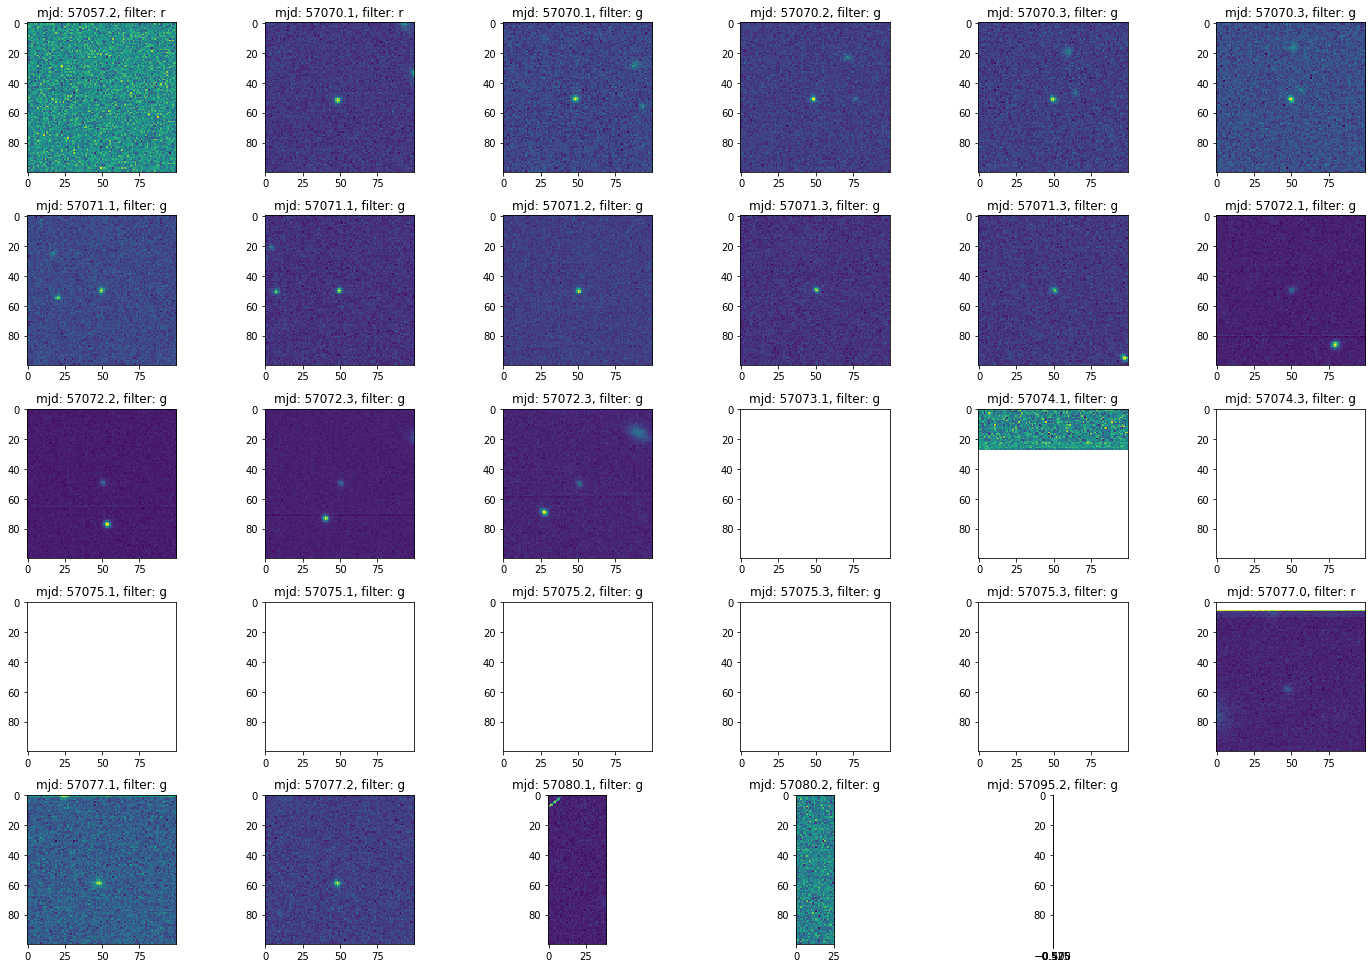

In [158]:
fig = plt.figure(figsize=(20, 16))
for i in range(len(sci_stamp_list)):
    fig.add_subplot(6, 6, i+1)
    plt.imshow(sci_stamp_list[i])
    plt.title('mjd: %.1f, filter: %s' % (sci_mjd_list[i], sci_filt_list[i]))
plt.tight_layout()

In [159]:
sci_im_array = np.zeros(np.shape(sci_stamp_list[1]))
for i in range(1,15):
    sci_im_array += sci_stamp_list[i]

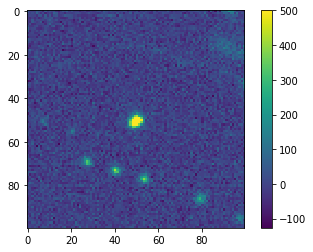

In [160]:
plt.imshow(sci_im_array, vmax=500)
plt.colorbar()